## Project: Orange juice brand prediction using machine learning
- **Source**: Stine, Robert A., Foster, Dean P., Waterman, Richard P. Business Analysis Using Regression (1998). Published by Springer.
- **Date**: 10/15/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Load libraries and custom models
# Basics ---------------------------------------------------------------
import os
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, 
    LabelEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    cohen_kappa_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.utils import resample
# Logging --------------------------------------------------------------
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data and get a glimpse
# 1.1 Load file, get info
url = 'https://raw.githubusercontent.com/selva86/' + \
'datasets/master/orange_juice_withmissing.csv'
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase        1070 non-null   object 
 1   WeekofPurchase  1070 non-null   int64  
 2   StoreID         1069 non-null   float64
 3   PriceCH         1069 non-null   float64
 4   PriceMM         1066 non-null   float64
 5   DiscCH          1068 non-null   float64
 6   DiscMM          1066 non-null   float64
 7   SpecialCH       1068 non-null   float64
 8   SpecialMM       1065 non-null   float64
 9   LoyalCH         1065 non-null   float64
 10  SalePriceMM     1065 non-null   float64
 11  SalePriceCH     1069 non-null   float64
 12  PriceDiff       1069 non-null   float64
 13  Store7          1070 non-null   object 
 14  PctDiscMM       1065 non-null   float64
 15  PctDiscCH       1068 non-null   float64
 16  ListPriceDiff   1070 non-null   float64
 17  STORE           1068 non-null   f

In [3]:
# 1.2 Get a sample
df_raw.sample(12, random_state=2024)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
963,MM,229,1.0,1.69,1.69,0.00,0.00,0.0,0.0,0.680000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1.0
219,CH,272,7.0,1.86,2.13,0.00,0.00,0.0,0.0,0.989732,2.13,1.86,0.27,Yes,0.000000,0.000000,0.27,0.0
770,MM,229,2.0,1.69,1.69,0.00,0.00,0.0,0.0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,2.0
556,MM,275,1.0,1.96,2.13,0.00,0.74,0.0,1.0,0.477037,1.39,1.96,-0.57,No,0.347418,0.000000,0.17,1.0
793,MM,257,1.0,1.76,2.18,0.00,0.00,0.0,0.0,0.083886,2.18,1.76,0.42,No,0.000000,0.000000,0.42,1.0
952,MM,267,2.0,1.86,2.18,0.00,0.40,0.0,1.0,0.003817,1.78,1.86,-0.08,No,0.183486,0.000000,0.32,2.0
1,CH,239,1.0,1.75,1.99,0.00,0.30,0.0,1.0,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1.0
833,MM,241,3.0,1.79,2.23,0.00,0.00,0.0,0.0,0.204800,2.23,1.79,0.44,No,0.000000,0.000000,0.44,3.0
824,CH,232,4.0,1.79,2.09,0.00,0.00,0.0,0.0,0.867041,2.09,1.79,0.30,No,0.000000,0.000000,0.30,4.0
138,CH,278,2.0,1.99,2.18,0.00,0.00,0.0,0.0,0.988272,2.18,1.99,0.19,No,0.000000,0.000000,0.19,2.0


### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [ ]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop(
        ['weekofpurchase','pctdiscch','pctdiscmm',
         'pricediff','listpricediff','store'], axis=1
    )
    .rename(columns={'purchase':'target'})
    .astype({'target':'category',
             'storeid':'category',
             'store7':'category',
             'specialch':'category',
             'specialmm':'category'})
)
#.iloc[:, [-1] + [x for x in range(df_raw.shape[1]) if x!=4]]

In [5]:
# 2.2 Create the final dataset with the target iin the first column
df = (
    df_interim
    .copy()
    .reindex(
        columns = ['target'] + 
        [c for c in df_interim.columns.to_list() if c not in ['target']]
    )
)

### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [6]:
# Step 3. EDA
# 3.1 Create train and test splits
df_train, df_test = train_test_split(
    df, stratify=df['target'], test_size=0.2, random_state=2024
)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, 340 to 504
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   target       856 non-null    category
 1   storeid      856 non-null    category
 2   pricech      856 non-null    float64 
 3   pricemm      854 non-null    float64 
 4   discch       854 non-null    float64 
 5   discmm       853 non-null    float64 
 6   specialch    854 non-null    category
 7   specialmm    852 non-null    category
 8   loyalch      854 non-null    float64 
 9   salepricemm  851 non-null    float64 
 10  salepricech  855 non-null    float64 
 11  store7       856 non-null    category
dtypes: category(5), float64(7)
memory usage: 58.4 KB


In [7]:
# 3.2 Get numerical and category summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
pricech,856.0,1.869661,0.101328,1.690000,1.79,1.860000,1.990000,2.090000
pricemm,854.0,2.086792,0.133189,1.690000,1.99,2.090000,2.180000,2.290000
discch,854.0,0.050328,0.115144,0.000000,0.00,0.000000,0.000000,0.500000
discmm,853.0,0.126166,0.213678,0.000000,0.00,0.000000,0.240000,0.800000
loyalch,854.0,0.562177,0.309084,0.000011,0.32,0.590665,0.843288,0.999947
salepricemm,851.0,1.960646,0.253729,1.190000,1.69,2.090000,2.180000,2.290000
salepricech,855.0,1.819404,0.142025,1.390000,1.75,1.860000,1.890000,2.090000


,count,unique,top,freq
target,856,2,CH,522
storeid,856.0,5.0,7.0,274.0
specialch,854.0,2.0,0.0,732.0
specialmm,852.0,2.0,0.0,711.0
store7,856,2,No,582


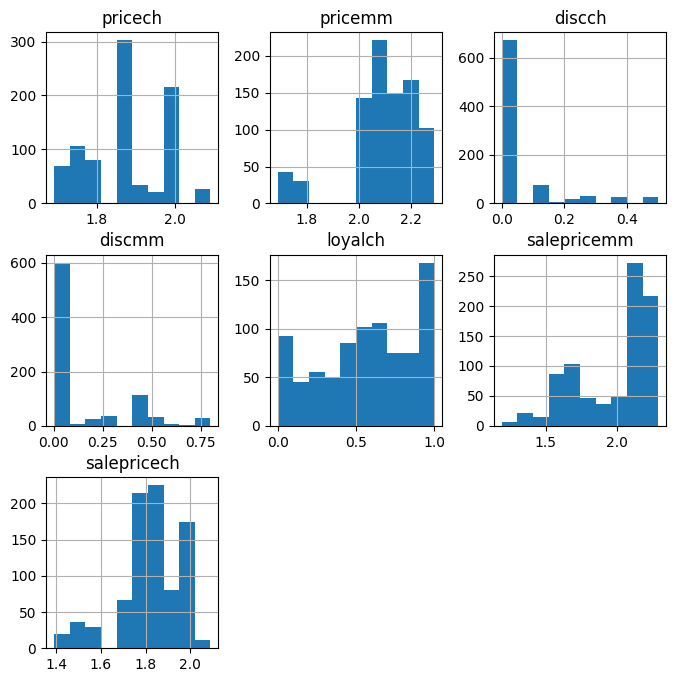

In [8]:
# 3.3 Perform univariate analysis - number
df_train.hist(figsize=(8,8))
plt.show()

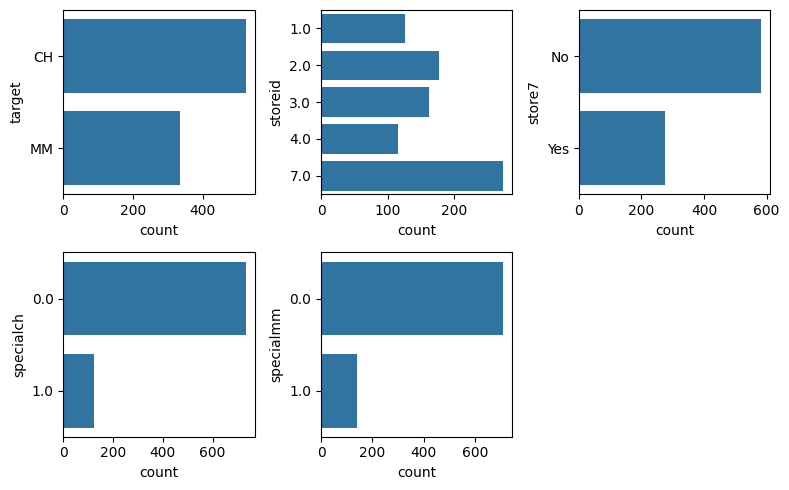

In [9]:
# 3.4 Perform univariate analysis - category
fig, ax = plt.subplots(2,3, figsize=(8,5))
sns.countplot(data=df_train, y='target', ax=ax[0,0])
sns.countplot(data=df_train, y='storeid', ax=ax[0,1])
sns.countplot(data=df_train, y='store7', ax=ax[0,2])
sns.countplot(data=df_train, y='specialch', ax=ax[1,0])
sns.countplot(data=df_train, y='specialmm', ax=ax[1,1])
fig.delaxes(ax[1,2])
fig.tight_layout()
plt.show()

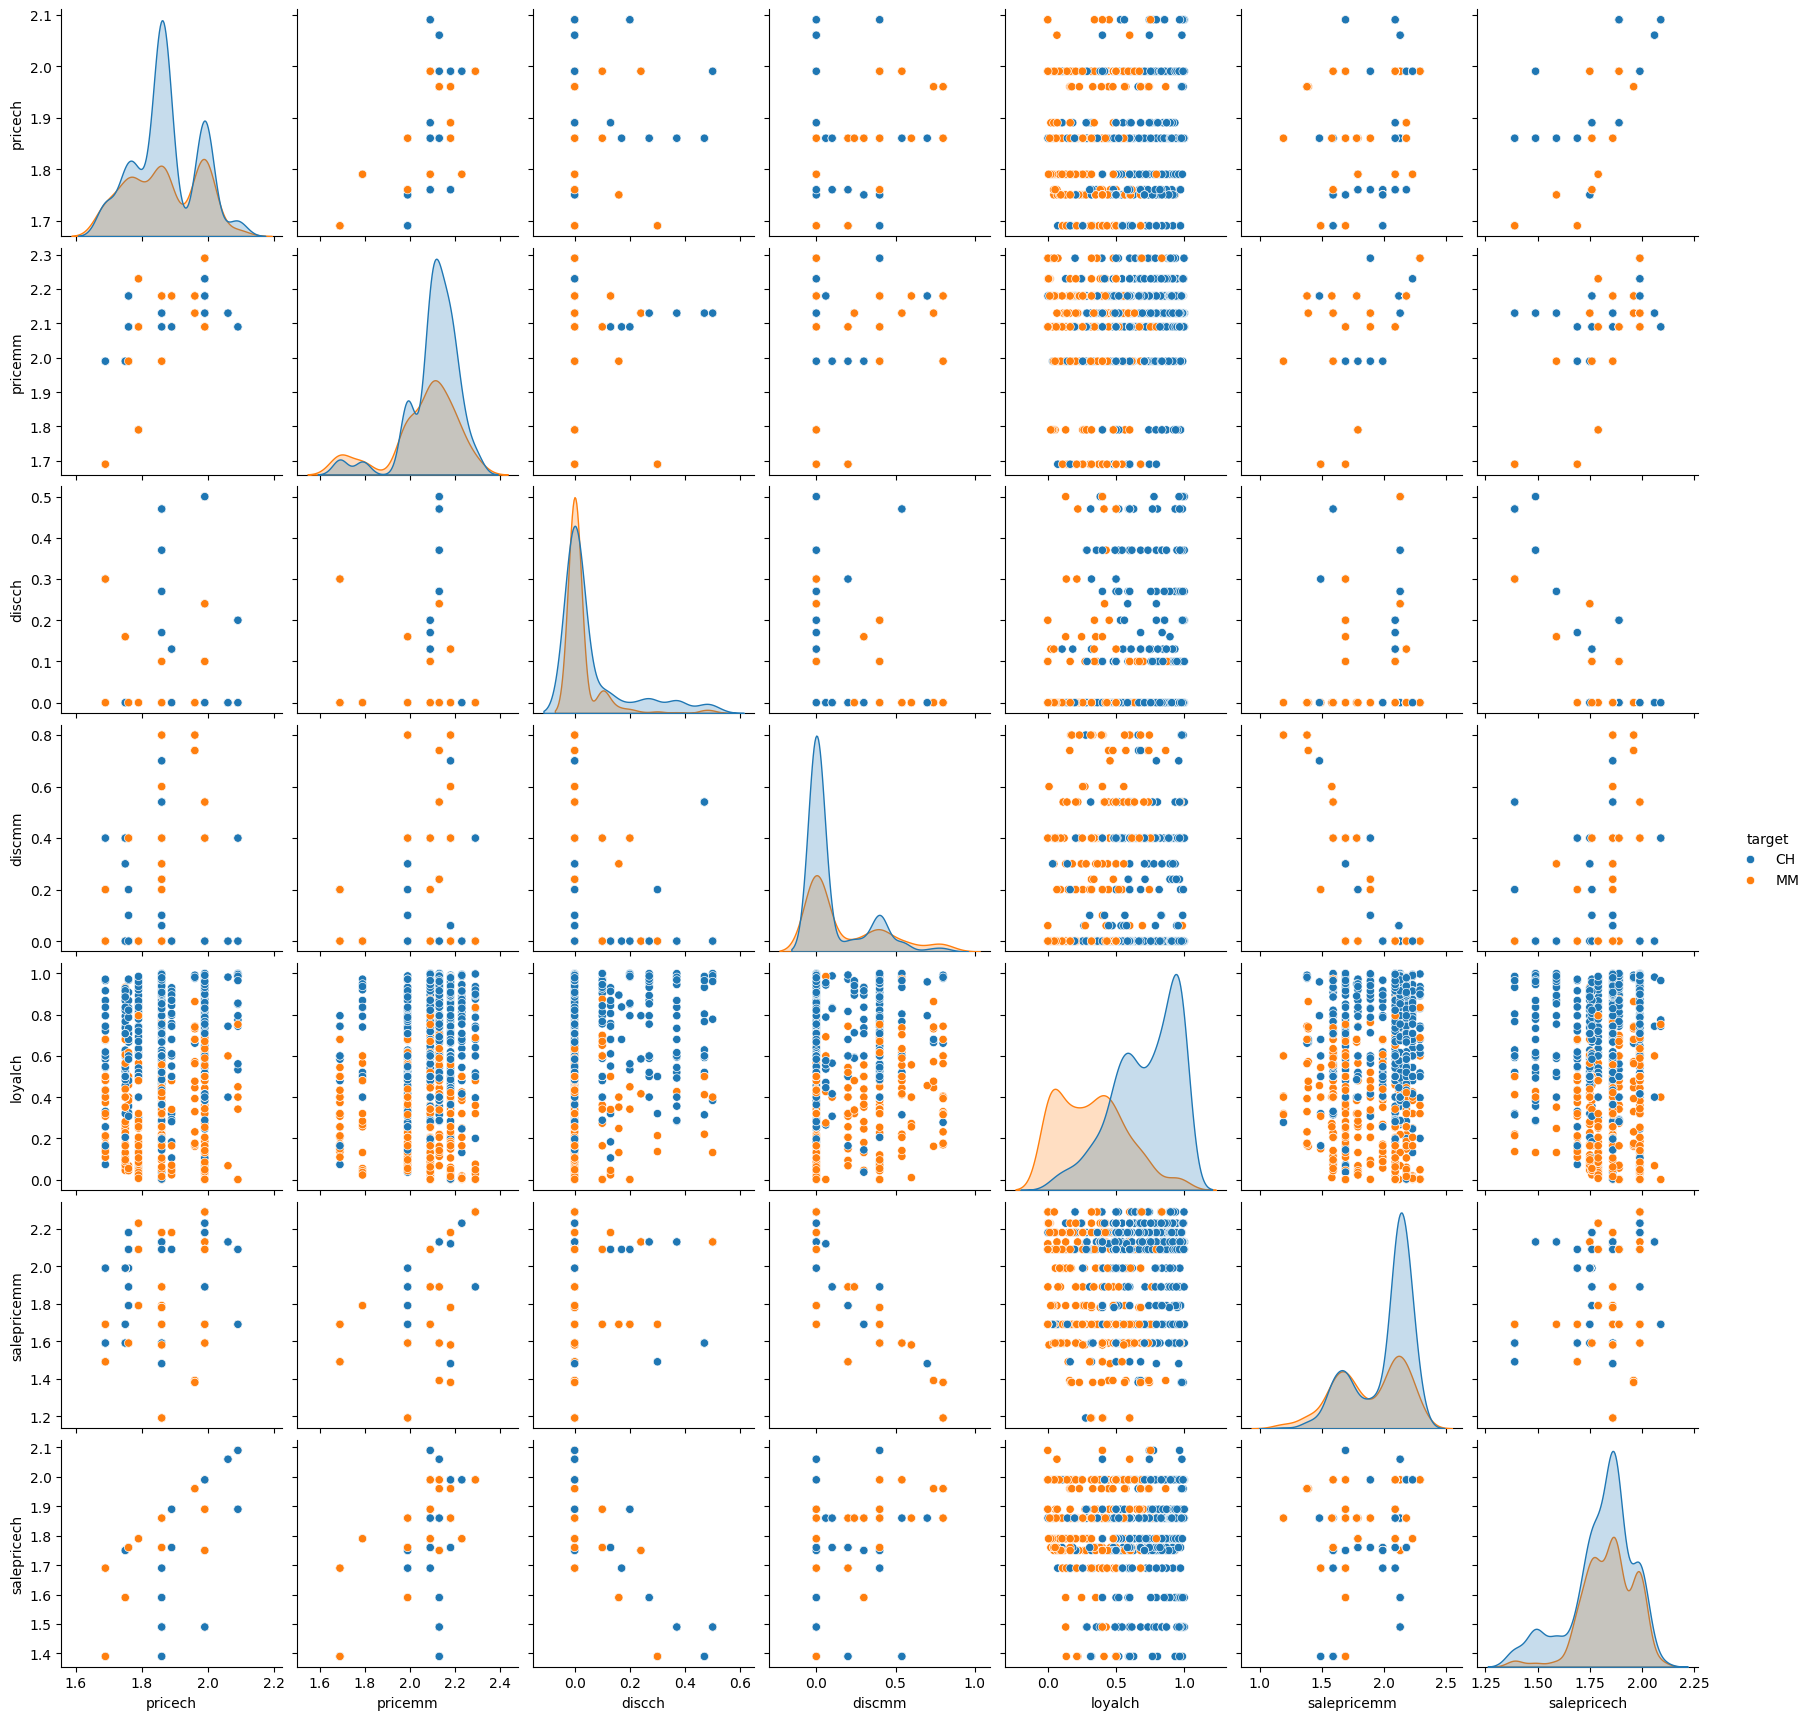

In [10]:
# 3.5 Perform bivariate analysis - Numerical vs target
sns.pairplot(data=df_train, hue='target')
plt.show()

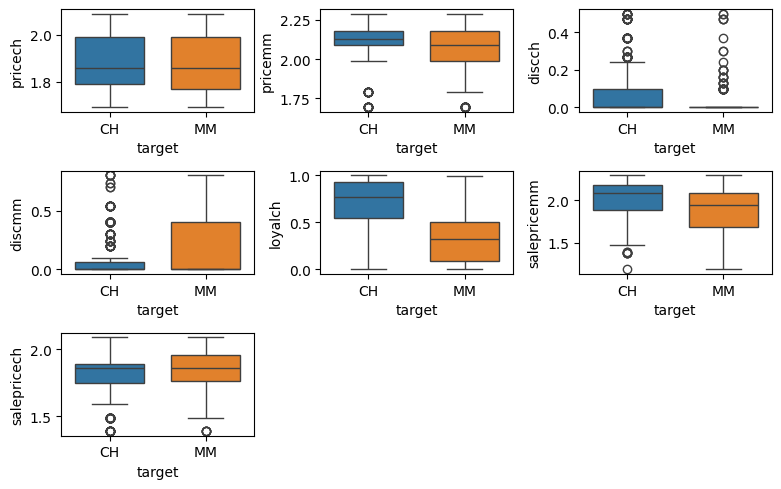

In [11]:
# 3.5.1 View boxplots vs target
fig, ax = plt.subplots(3,3, figsize=(8,5))
axs = ax.flatten()
numcols = df_train.select_dtypes('number').columns
for i in range(len(numcols)):
    sns.boxplot(data=df_train, y=numcols[i], x='target', 
                hue='target', gap=.1, ax=axs[i], legend=None)
fig.delaxes(axs[7])
fig.delaxes(axs[8])
fig.tight_layout()
plt.show()

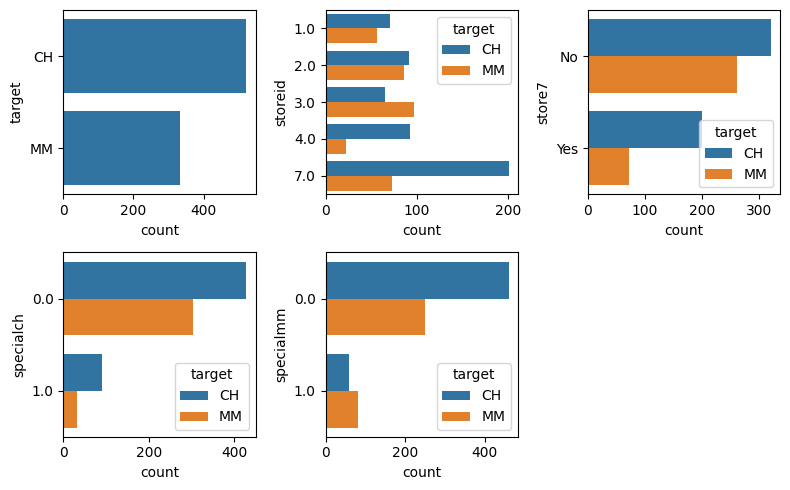

In [12]:
# 3.6 Perform bivariate analysis - Categorical vs target
fig, ax = plt.subplots(2,3, figsize=(8,5))
sns.countplot(data=df_train, y='target', ax=ax[0,0])
sns.countplot(data=df_train, y='storeid', hue='target', ax=ax[0,1])
sns.countplot(data=df_train, y='store7', hue='target', ax=ax[0,2])
sns.countplot(data=df_train, y='specialch', hue='target', ax=ax[1,0])
sns.countplot(data=df_train, y='specialmm', hue='target', ax=ax[1,1])
fig.delaxes(ax[1,2])
fig.tight_layout()
plt.show()

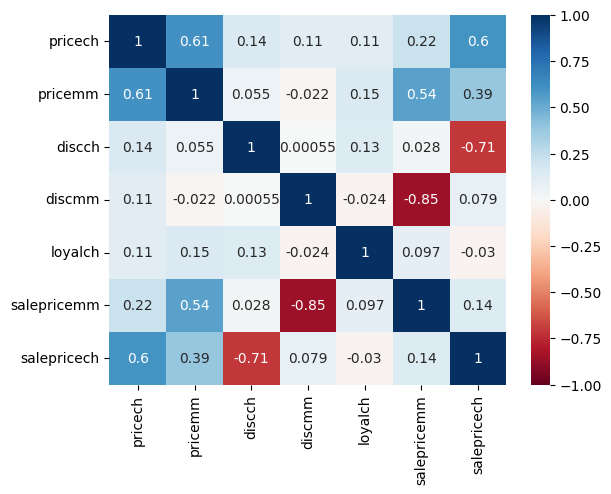

In [13]:
# 3.7 Perform correlation analysis
sns.heatmap(
    df_train.select_dtypes('number').corr(), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [14]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.drop(['target'], axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=1)
X_test = df_test.drop(['target'], axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [15]:
# 4.2 Encode the response 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [16]:
# 4.3 Create a pipeline for data
cat_cols = X_train.select_dtypes('category').columns
num_cols = X_train.select_dtypes('number').columns

cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('minmax', MinMaxScaler())
])

processor = ColumnTransformer(transformers=[
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [17]:
# 4.4 Create a pipeline for model training
clf_rf = Pipeline([
    ('proc',processor),
    ('rfclf', RandomForestClassifier(class_weight='balanced', random_state=2024))
])

In [18]:
# 4.5 Train the model 
clf_rf.fit(X_train, y_train_enc)

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['storeid', 'specialch', 'specialmm', 'store7'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['pricech', 'pricemm', 'discch', 'discmm', 'loyalch', 'salepricemm',
       'salepricech'],
      dtype='object'))])),
                ('rfclf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=2024))])

Accuracy: 0.808
F1 Score: 0.742
ROC AUC score: 0.921
Precision: 0.776
Recall: 0.711
              precision    recall  f1-score   support

          CH       0.83      0.87      0.85       131
          MM       0.78      0.71      0.74        83

    accuracy                           0.81       214
   macro avg       0.80      0.79      0.79       214
weighted avg       0.81      0.81      0.81       214



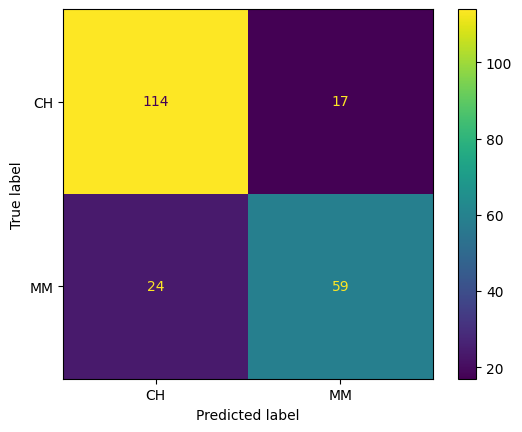

In [19]:
# 4.6 Predict on test data and get accuracy and confusion matrix
y_hat = clf_rf.predict(X_test)
y_hat_score = clf_rf.predict_proba(X_test)[:,1]
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat):.3f}')
print(f'ROC AUC score: {roc_auc_score(y_test_enc, y_hat_score):.3f}')
print(f'Precision: {precision_score(y_test_enc, y_hat, pos_label=1):.3f}')
print(f'Recall: {recall_score(y_test_enc, y_hat, pos_label=1):.3f}')
print(classification_report(y_test_enc, y_hat, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=label_encoder.classes_)
plt.show()

In [20]:
# 4.7 Create crossvalidation to finde best hyperparameters
params = {
    'rfclf__max_depth': [2,3,4,None],
    'rfclf__n_estimators': [50,100,150],
    'rfclf__min_samples_split': [2,3,4]
}
grid_search = GridSearchCV(clf_rf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('proc',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['storeid', 'specialch', 'specialmm', 'store7'], dtype='object')),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['pricech', 'pricemm', 'discch', 'discmm', 'loyalch', 'salepricemm',
       'salepricech'],
      dtype='object'))])),
                                       ('rfclf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=2024))]),
             n_jobs=-1,
             param_grid={'rfclf__max_depth': [2, 3, 4, None],
                         'rfclf__min_samples_split': [2, 3, 4],
                         'rfclf__n_estimators': [50, 100, 150]})

Accuracy: 0.874
F1 Score: 0.840
ROC AUC score: 0.942
Precision: 0.826
Recall: 0.855
              precision    recall  f1-score   support

          CH       0.91      0.89      0.90       131
          MM       0.83      0.86      0.84        83

    accuracy                           0.87       214
   macro avg       0.87      0.87      0.87       214
weighted avg       0.87      0.87      0.87       214



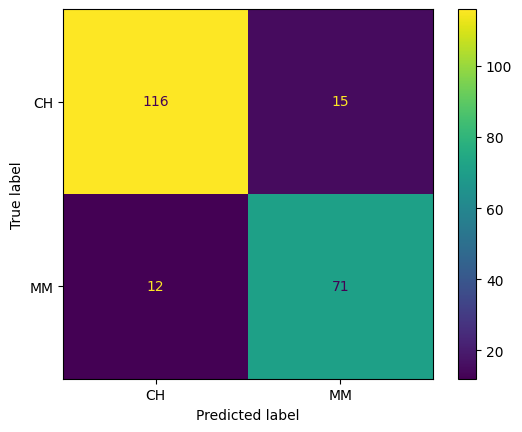

In [21]:
# 4.8 Predict on test data and get accuracy and confusion matrix with best model
best_clf_rf = grid_search.best_estimator_
y_hat_best = best_clf_rf.predict(X_test)
y_hat_best_score = best_clf_rf.predict_proba(X_test)[:,1]
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat_best):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat_best):.3f}')
print(f'ROC AUC score: {roc_auc_score(y_test_enc, y_hat_best_score):.3f}')
print(f'Precision: {precision_score(y_test_enc, y_hat_best, pos_label=1):.3f}')
print(f'Recall: {recall_score(y_test_enc, y_hat_best, pos_label=1):.3f}')
print(classification_report(y_test_enc, y_hat_best, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_best, display_labels=label_encoder.classes_)
plt.show()

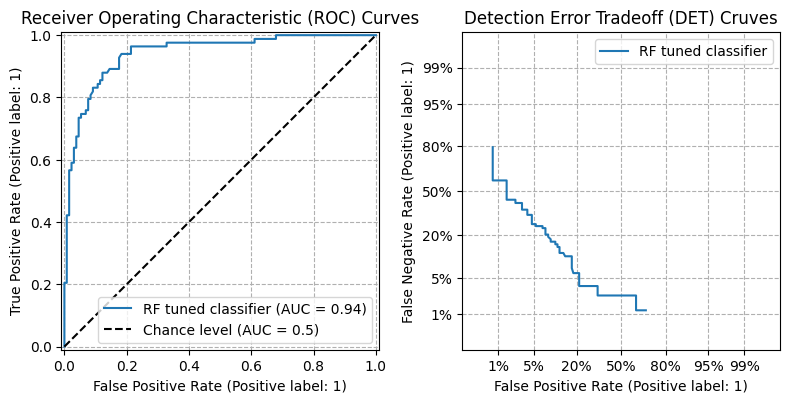

In [22]:
# 4.9 Visualize the probabilities of scores of the classifier
fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(8,8))
RocCurveDisplay.from_predictions(
    y_test_enc, y_hat_best_score, ax=ax_roc, 
    plot_chance_level=True, name='RF tuned classifier'
)
DetCurveDisplay.from_predictions(
    y_test_enc, y_hat_best_score, ax=ax_det, 
    name='RF tuned classifier'
)
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curves")
ax_det.set_title("Detection Error Tradeoff (DET) Cruves")
ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')
ax_det.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

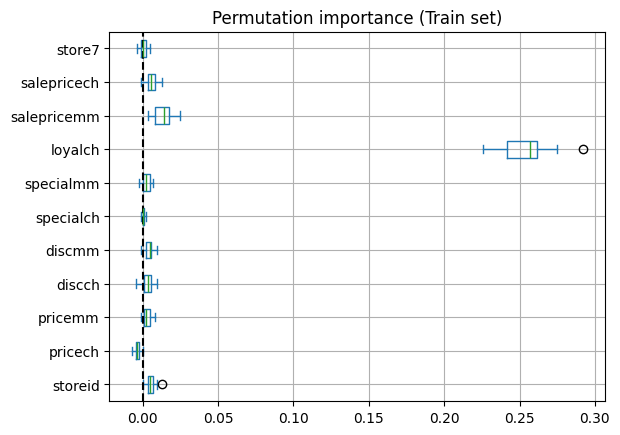

In [23]:
# 4.10 Get the importance of variables
importance = permutation_importance(best_clf_rf, X_train, y_train_enc, n_repeats=25, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [24]:
# 4.11 Calculate estimates for model using resampling
n_iterations = 30
auc_scores = []
kappa_scores = []
f1_scores = []
for i in range(n_iterations):
    # Create a boostrap sample
    df_rs = resample(df_train)
    # Split the resample data
    df_train_rs, df_test_rs = train_test_split(
        df_rs, test_size=0.2, random_state=2024 
    )
    X_train_rs = df_train_rs.drop(['target'], axis=1).reset_index(drop=True)
    y_train_rs = df_train_rs['target'].reset_index(drop=True)
    X_test_rs = df_test_rs.drop(['target'], axis=1).reset_index(drop=True)
    y_test_rs = df_test_rs['target'].reset_index(drop=True)
    y_train_rs_enc = label_encoder.fit_transform(y_train_rs)
    y_test_rs_enc = label_encoder.transform(y_test_rs)
    # Train the model
    best_clf_rf.fit(X_train_rs, y_train_rs_enc)
    y_hat_best_rs = best_clf_rf.predict(X_test_rs)
    # Predict probabilities
    y_hat_best_rs_score = best_clf_rf.predict_proba(X_test_rs)[:,1]
    # Calculate metrics
    auc = roc_auc_score(y_test_rs_enc, y_hat_best_rs_score)
    kappa = cohen_kappa_score(y_test_rs_enc, y_hat_best_rs) 
    f1 = f1_score(y_test_rs_enc, y_hat_best_rs)
    auc_scores.append(auc)
    kappa_scores.append(kappa)
    f1_scores.append(f1)

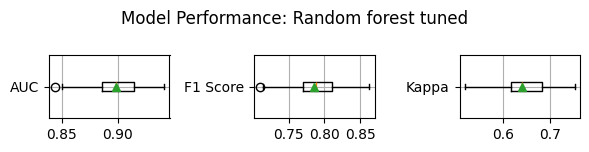

AUC: 0.90 +/- 0.04
F1 Scores: 0.79 +/- 0.07
Kappa: 0.64 +/- 0.11


In [25]:
# 4.12 Plot the values and the intervals
fig, ax = plt.subplots(1,3, figsize=(6,1.5))
ax[0].boxplot(x=auc_scores, vert=False, showmeans=True)
ax[0].grid(True)
ax[0].set_yticks([1],['AUC'])
ax[1].boxplot(x=f1_scores, vert=False, showmeans=True)
ax[1].grid(True)
ax[1].set_yticks([1],['F1 Score'])
ax[2].boxplot(x=kappa_scores, vert=False, showmeans=True)
ax[2].grid(True)
ax[2].set_yticks([1],['Kappa'])
plt.suptitle('Model Performance: Random forest tuned')
plt.tight_layout()
plt.show()
print(f'AUC: {np.mean(auc_scores):.2f} +/- {1.96*np.std(auc_scores):.2f}')
print(f'F1 Scores: {np.mean(f1_scores):.2f} +/- {1.96*np.std(f1_scores):.2f}')
print(f'Kappa: {np.mean(kappa_scores):.2f} +/- {1.96*np.std(kappa_scores):.2f}')

### 5. Model saving
**Objective**: Save the model and some critical information we consider necessary

In [26]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
model_dict = {
    'model': best_clf_rf,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'algorithm_name': 'Random forest'
}

In [27]:
# 5.2 Save the model dictionary
try:
    joblib.dump(model_dict, '../models/orange_juice_model_dict.joblib')
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")

### 6. Notes
**Objective**: Add some comments or experiments done on experimenting

In [28]:
# 6.1 Get parametes of an algorithm
clf_rf['rfclf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2024,
 'verbose': 0,
 'warm_start': False}

In [29]:
# 6.2 Load best parameters
best_clf_rf = grid_search.best_estimator_
best_clf_rf.get_params()

{'memory': None,
 'steps': [('proc', ColumnTransformer(transformers=[('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore'))]),
                                    Index(['storeid', 'specialch', 'specialmm', 'store7'], dtype='object')),
                                   ('num',
                                    Pipeline(steps=[('imputer', SimpleImputer())]),
                                    Index(['pricech', 'pricemm', 'discch', 'discmm', 'loyalch', 'salepricemm',
          'salepricech'],
         dtype='object'))])),
  ('rfclf',
   RandomForestClassifier(class_weight='balanced', max_depth=4,
                          min_samples_split=4

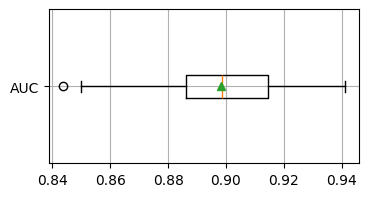

In [30]:
# 6.3 Make a boxplot on top of plt
plt.figure(figsize=(4,2))
plt.boxplot(x=auc_scores, label='AUC', vert=False, showmeans=True)
plt.yticks([1], ['AUC'])
plt.grid(True)
plt.show()

In [1]:
lista1 = ['Pe','Pa','Pu']
lista2 = [1,2,3]
iterable = zip(lista1,lista2)
miterable = list(iterable)
miterable

[('Pe', 1), ('Pa', 2), ('Pu', 3)]

In [2]:
def funce():
    print("Hello World")

In [3]:
funce()

Hello World
